<a href="https://colab.research.google.com/github/abbyambita/pneumonia_detection/blob/master/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls  '/content/drive/My Drive/cs239/'

checkpoint.pth			  three_classes
densenet121.ipynb		  two_classes
preprocessed			  two_classes_downsampled
resnet-1024-256-2-91accuracy.pth  two_classes_upsampled
test.ipynb			  Untitled0.ipynb


In [0]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

plt.ion()

In [0]:
import gc

## MEM utils ##
def mem_report():
    '''Report the memory usage of the tensor.storage in pytorch
    Both on CPUs and GPUs are reported'''

    def _mem_report(tensors, mem_type):
        '''Print the selected tensors of type
        There are two major storage types in our major concern:
            - GPU: tensors transferred to CUDA devices
            - CPU: tensors remaining on the system memory (usually unimportant)
        Args:
            - tensors: the tensors of specified type
            - mem_type: 'CPU' or 'GPU' in current implementation '''
        print('Storage on %s' %(mem_type))
        print('-'*LEN)
        total_numel = 0
        total_mem = 0
        visited_data = []
        for tensor in tensors:
            if tensor.is_sparse:
                continue
            # a data_ptr indicates a memory block allocated
            data_ptr = tensor.storage().data_ptr()
            if data_ptr in visited_data:
                continue
            visited_data.append(data_ptr)

            numel = tensor.storage().size()
            total_numel += numel
            element_size = tensor.storage().element_size()
            mem = numel*element_size /1024/1024 # 32bit=4Byte, MByte
            total_mem += mem
            element_type = type(tensor).__name__
            size = tuple(tensor.size())

            print('%s\t\t%s\t\t%.2f' % (
                element_type,
                size,
                mem) )
        print('-'*LEN)
        print('Total Tensors: %d \tUsed Memory Space: %.2f MBytes' % (total_numel, total_mem) )
        print('-'*LEN)

    LEN = 65
    print('='*LEN)
    objects = gc.get_objects()
    print('%s\t%s\t\t\t%s' %('Element type', 'Size', 'Used MEM(MBytes)') )
    tensors = [obj for obj in objects if torch.is_tensor(obj)]
    cuda_tensors = [t for t in tensors if t.is_cuda]
    host_tensors = [t for t in tensors if not t.is_cuda]
    _mem_report(cuda_tensors, 'GPU')
    _mem_report(host_tensors, 'CPU')
    print('='*LEN)

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [0]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight    

In [85]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((224, 224)),   
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = '/content/drive/My Drive/cs239/two_classes/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train']}

#weights = make_weights_for_balanced_classes(image_datasets['train'].imgs, len(image_datasets['train'].classes))                                                                
#weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     

targets = image_datasets['train'].targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.1, random_state=42, shuffle=True, stratify=targets)


print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataloaders = {'test': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4, num_workers=4, sampler = test_sampler)}

dataloaders.update({'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                                           sampler = train_sampler, num_workers=4, pin_memory=True)} )

#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes = {
    'train': len(train_idx),
    'test': len(test_idx)
}
class_names = image_datasets['train'].classes

print(dataset_sizes['train'])
print(dataset_sizes['test'])



(array([0, 1]), array([1207, 3500]))
(array([0, 1]), array([134, 389]))
4707
523


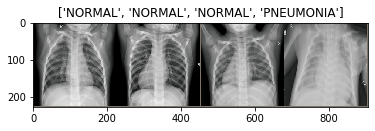

In [86]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
# Build and train your network
# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False


In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

#original dropout parameter: 0.2
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('dp1', nn.Dropout(0.2)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 256)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

#classifier = nn.Sequential(OrderedDict([
#                          ('fc1', nn.Linear(2048, 1024)),
#                          ('dp1', nn.Dropout(0.3)),
#                          ('relu', nn.ReLU()),
#                          ('fc2', nn.Linear(1024, 256)),
#                          ('relu2', nn.ReLU()),
#                          ('fc3', nn.Linear(256, 2)),
#                          ('output', nn.LogSoftmax(dim=1))
#                          ]))

#classifier = nn.Sequential(OrderedDict([
#                                        ('fcl1', nn.Linear(1024,256)),
#                                        ('dp1', nn.Dropout(0.3)),
#                                        ('r1', nn.ReLU()),
#                                        ('fcl2', nn.Linear(256,32)),
#                                        ('dp2', nn.Dropout(0.3)),
#                                        ('r2', nn.ReLU()),
#                                        ('fcl3', nn.Linear(32,2)),
#                                        ('out', nn.LogSoftmax(dim=1))
#                                        ]))


# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
train_losses = []
test_losses = []
#remove scheduler

#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=3):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [90]:
#Train a model with a pre-trained network

if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()


 #Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.fc.parameters(), lr = 0.0001, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

model_ft = train_model(model, criterion, optimizer, num_epochs=5)

Using GPU: True
Epoch 1/5
----------
train Loss: 0.3186 Acc: 0.8651
test Loss: 0.1274 Acc: 0.9541

Epoch 2/5
----------
train Loss: 0.2646 Acc: 0.8955
test Loss: 0.1358 Acc: 0.9503

Epoch 3/5
----------
train Loss: 0.2622 Acc: 0.8936
test Loss: 0.1106 Acc: 0.9656

Epoch 4/5
----------
train Loss: 0.2514 Acc: 0.9016
test Loss: 0.1010 Acc: 0.9675

Epoch 5/5
----------
train Loss: 0.2445 Acc: 0.8991
test Loss: 0.1043 Acc: 0.9598

Training complete in 8m 17s
Best valid accuracy: 0.967495


In [91]:
mem_report()

Element type	Size			Used MEM(MBytes)
Storage on GPU
-----------------------------------------------------------------
Tensor		(64, 3, 7, 7)		0.04
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(64, 64, 1, 1)		0.02
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(64, 64, 3, 3)		0.14
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(256, 64, 1, 1)		0.06
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		()		0.00
Tensor		(256, 64, 1, 1)		0.06
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		()		0.00
Tensor		(64, 256, 1, 1)		0.06
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(64, 64, 3, 3)		0.14
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor	

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "



Parameter		(512,)		0.00
Parameter		(512,)		0.00
Parameter		(2048, 512, 1, 1)		4.00
Parameter		(2048,)		0.01
Parameter		(2048,)		0.01
Parameter		(512, 2048, 1, 1)		4.00
Parameter		(512,)		0.00
Parameter		(512,)		0.00
Parameter		(512, 512, 3, 3)		9.00
Parameter		(512,)		0.00
Parameter		(512,)		0.00
Parameter		(2048, 512, 1, 1)		4.00
Parameter		(2048,)		0.01
Parameter		(2048,)		0.01
Parameter		(1024, 2048)		8.00
Parameter		(1024,)		0.00
Parameter		(256, 1024)		1.00
Parameter		(256,)		0.00
Parameter		(2, 256)		0.00
Parameter		(2,)		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		()		0.00
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		()		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(64,)		0.00
Tensor		(64,)		0.00
Tensor		()		0.00
Tensor		(256,)		0.00
Tensor		(256,)		0.00
Tensor		()		0.0

In [92]:
!nvidia-smi

Fri Nov 22 03:31:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    32W / 250W |   2263MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def evaluate_performance(labels, preds):
  label = ['normal', 'pneumonia']
  #print(confusion_matrix)
  conf_matrix = confusion_matrix(labels, preds)
  print(conf_matrix)

  # Per-class accuracy
  class_accuracy=100*conf_matrix.diagonal()/conf_matrix.sum(1)
  print(class_accuracy)

  print("Accuracy score:", accuracy_score(labels, preds))
  print(classification_report(labels, preds))

  plt.figure()
  plot_confusion_matrix(conf_matrix, classes=['Normal', 'Pneumonia'],
                      title='Confusion matrix')
  plt.show()

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy())

Testing Accuracy: 0.008
Testing Accuracy: 0.015
Testing Accuracy: 0.023
Testing Accuracy: 0.031
Testing Accuracy: 0.038
Testing Accuracy: 0.046
Testing Accuracy: 0.053
Testing Accuracy: 0.061
Testing Accuracy: 0.069
Testing Accuracy: 0.074
Testing Accuracy: 0.082
Testing Accuracy: 0.090
Testing Accuracy: 0.097
Testing Accuracy: 0.103
Testing Accuracy: 0.111
Testing Accuracy: 0.116
Testing Accuracy: 0.124
Testing Accuracy: 0.132
Testing Accuracy: 0.137
Testing Accuracy: 0.145
Testing Accuracy: 0.153
Testing Accuracy: 0.158
Testing Accuracy: 0.166
Testing Accuracy: 0.174
Testing Accuracy: 0.177
Testing Accuracy: 0.185
Testing Accuracy: 0.193
Testing Accuracy: 0.200
Testing Accuracy: 0.208
Testing Accuracy: 0.216
Testing Accuracy: 0.223
Testing Accuracy: 0.231
Testing Accuracy: 0.239
Testing Accuracy: 0.246
Testing Accuracy: 0.254
Testing Accuracy: 0.261
Testing Accuracy: 0.269
Testing Accuracy: 0.277
Testing Accuracy: 0.284
Testing Accuracy: 0.292
Testing Accuracy: 0.300
Testing Accuracy

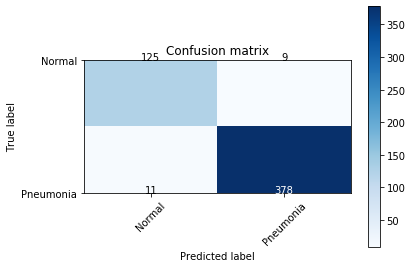

In [95]:
test(model, dataloaders, device)

In [0]:
# Save the checkpoint 
num_epochs = 30
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [2, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size':2,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, '/content/drive/My Drive/cs239/resnet-1024-256-2-95accuracy.pth')

In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(1024, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('90_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

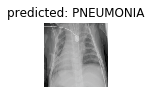

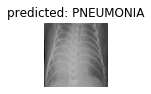

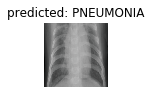

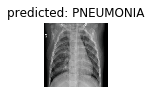

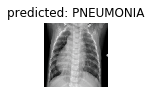

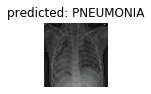

In [98]:
visualize_model(model_ft)

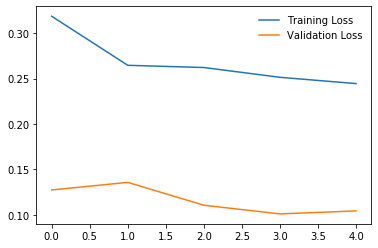

In [99]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)